<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/utils/RGB_Stretch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# SAR Application: Creating RGB Images
### I. How to create SAR quicklook images of Creating RGB Images? 

* Useful Products: 3 SAR Polarizations
* Useful Wavelengths: 
* Instructions to View: 
* Qualitative Browse Products: How does the user know there is something in the image related to flooding before they develop/implement any algorithms? 

### II. How to interpret SAR images of Creating RGB Images?

The overlay of different polarization channels allows users to visually classify a scene by its backscattering mechanism, such as surface scattering (strong HH and VV return), volume scattering (strong HV return) and double-bounce scattering (strong HH return). RGB or "Red Green Blue" images, have these polarization channels encoded into different color channels, and the resulting color image can be employed to interpret physical information on the ground.

#### Backscatter Mechanisms:
- Specular Scattering: when there is a smooth surface, such as open water. In specular scattering, the signal scatters away from the radar. As a result, open water appears dark in the image.
- Rough Scattering: slight roughness, where some but not all of the signal scatters away from the radar. This could be due to wind roughening or some vegetation.
- Double Bounce: most of the signal is returned to the sensor, and these areas appear very bright in the image. This occurs in areas of flooded vegetation because of the interaction of the smooth water surface and vertical vegetation. Two smooth surfaces creating right angles.

#### RGB Interpretation: 

Generally, the double bounce polarization is the red channel, volume scattering is green, and surface is blue. Thus in RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests, vegetated fields, or urban areas. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter.

Close to black: open water bodies. This indicates that the first polarimetric channel, HH+VV, magnitude large compared to others, i.e. the amplitude of HV is weak and the phase argument of HHVV* is close to zero. This is characteristic of scattering over a surface. Bright and pink: double bounce (flooded vegetation, buildings). The expansion of the bright zones shows flood waters extending into urban sites. Over forested sites, images from the active sensor (SAR) shows inundation under the trees that is not evident in the optical imagery. Flooded grasses may go undetected owing to the L-band 24-cm wavelength. Generally, the green color indicates a dominant HV component, generally characteristic of vegetated zones.

#### Pauli Decomposition RGB:
One type of SAR RGB images are Pauli Decomposition RGBs. The Pauli color coding is based on a vector representation of linear combinations of scattering matrix elements. The resulting polarimetric channels HH+VV , HH-VV , HV are then associated to the blue, red and green colors respectively. In Pauli RGB images, areas dominated by green (HV) intensity are typically vegetated areas. Areas dominated by shades of pink (HH+HV) intensity are typically inundated forests, vegetated fields, or urban areas. Black and dark grey areas are usually smooth surfaces (roads, open water, smooth bare ground) where there is little radar backscatter.  

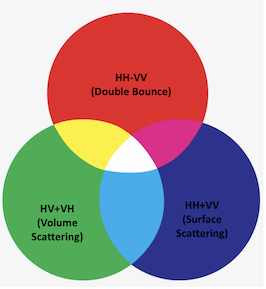

## Creating RGB Images

The content of this notebook is as follows:

1. [Running the Notebook](#s1)
2. [Create RGB](#s2)
3. [Create Pauli Decomposition RGB](#s3)
4. [RGB Examples](#s4)

<a name="s1"></a>
## 1. Running the Notebook

### Python Packages:
This routine using the following python libaries. Some are already included in the Google Colab environment and others are installed in the cell below before imported.

In [7]:
!pip install rasterio --quiet

## Import Packages
import rasterio as rio
import rasterio.plot
from rasterio.plot import show

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import math

<a name="s2"></a>
## 2. Create RGB 
### Red = HH, Green = HV, Blue = VV

1. Read in UAVSAR geotiffs
2. Plot Histogram of each Polarization
3. Calculate Standard Deviation
4. Stretch Image (normalize)
5. Stack Images
6. Plot RGB

To create RGB composites of Pre-Fire polarizations (2014) and Post-Fire polarizations (2017), first, read in each of the different polarizations. Then, remove outliers, scale the images, and stack the polarizations into the red, green, blue bands.

Read in UAVSAR Data from AWS

In [8]:
## Read in UAVSAR data from public AWS bucket
bucketAddress = 'http://d3v1ox4ttgtjq7.cloudfront.net' #this address could be prettier with a JPL domain name
discipline = 'test/'
dbAddress = 'nisar-calval-dev-west2.c0v0gfvvm2xq.us-west-2.rds.amazonaws.com'

HH2014 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_14158_003_141023_L090HHHH_CX_01_cropped.grd.tif'
HV2014 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_14158_003_141023_L090HVHV_CX_01_cropped.grd.tif'
VV2014 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_14158_003_141023_L090VVVV_CX_01_cropped.grd.tif'

HH2017 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_17122_003_171102_L090HHHH_CX_01_cropped.grd.tif'
HV2017 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_17122_003_171102_L090HVHV_CX_01_cropped.grd.tif'
VV2017 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_17122_003_171102_L090VVVV_CX_01_cropped.grd.tif'

In [9]:
def read_file(path):
  with rio.open(path) as ds:
    band = ds.read(1)
    return band

HH2014 = read_file(HH2014)
HV2014 = read_file(HV2014)
VV2014 = read_file(VV2014)

HH2017 = read_file(HH2017)
HV2017 = read_file(HV2017)
VV2017 = read_file(VV2017)

## Each read in raster is now an array. For example, this prints out the array for the VV polarization collected in 2014
print(VV2014)

[[0.00709833 0.00709833 0.00683147 ... 0.00148708 0.00148708 0.00153006]
 [0.00269053 0.00269053 0.00345481 ... 0.00144418 0.00144418 0.00212459]
 [0.00461945 0.00461945 0.00407214 ... 0.00137474 0.00137474 0.00188396]
 ...
 [0.2421128  0.5183544  0.21563019 ... 0.06151609 0.07801051 0.03170718]
 [0.39426258 0.5183544  0.21563019 ... 0.06227865 0.04125477 0.04125477]
 [0.0926581  0.3421318  0.3421318  ... 0.01645363 0.04291394 0.04291394]]


In [10]:
## Convert to from linear power to decibels (dB)
## Formula: 10*log10(DN)
def convert_db(data):
  db = 10*(math.log10(data))
  return db

convert_db2 = np.vectorize(convert_db)

HH2014 = convert_db2(HH2014)
HV2014 = convert_db2(HV2014)
VV2014 = convert_db2(VV2014)

HH2017 = convert_db2(HH2017)
HV2017 = convert_db2(HV2017)
VV2017 = convert_db2(VV2017)

In [ ]:
# ## Calculate standard deviation 
# HH2014_sd = np.std(HH2014)
# HV2014_sd = np.std(HV2014)
# VV2014_sd = np.std(VV2014)

# HH2017_sd = np.std(HH2017)
# HV2017_sd = np.std(HV2017)
# VV2017_sd = np.std(VV2017)

# std_dev = [HH2014_sd, HV2014_sd, VV2014_sd, HH2017_sd, HV2017_sd, VV2017_sd]
# std_dev

Plot a histogram of each polarization from 2014 and 2017
The histograms below show each the value spread for each polarization in 2014 and 2017. The middle dotted lines are the median and the solid lines are +/- one standard deviation from the mean.
https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-tiles-py

In [11]:
## Set range of histogram axes
x_range_min = -40
x_range_max = 15
y_range_min = 0
y_range_max = 0.08

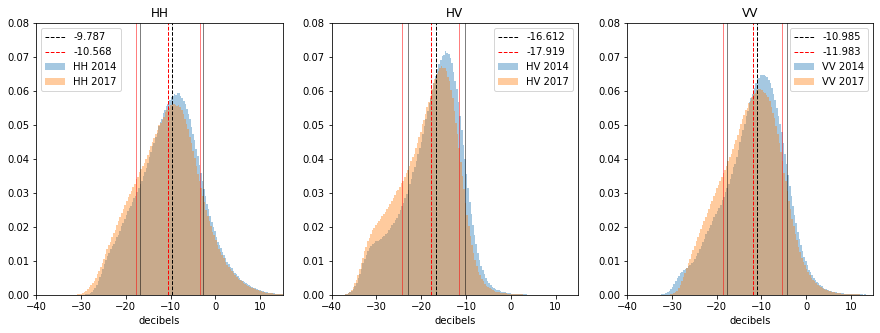

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n = 200

## Plotting each histogram and setting plot parameters
ax[0].hist(HH2014.ravel(), density=True, bins=n, alpha=0.4, label='HH 2014')
ax[0].axvline(np.median(HH2014), color='black', linestyle='dashed', linewidth=1, label=str(np.around(np.median(HH2014), decimals=3)))
ax[0].axvline(np.median(HH2014) + np.std(HH2014), color='black', linestyle='-', linewidth=0.5)
ax[0].axvline(np.median(HH2014) - np.std(HH2014), color='black', linestyle='-', linewidth=0.5)

ax[1].hist(HV2014.ravel(), density=True, bins=n, alpha=0.4, label='HV 2014')
ax[1].axvline(np.median(HV2014), color='black', linestyle='dashed', linewidth=1, label=str(np.around(np.median(HV2014), decimals=3)))
ax[1].axvline(np.median(HV2014) + np.std(HV2014), color='black', linestyle='-', linewidth=0.5)
ax[1].axvline(np.median(HV2014) - np.std(HV2014), color='black', linestyle='-', linewidth=0.5)

ax[2].hist(VV2014.ravel(), density=True, bins=n, alpha=0.4, label='VV 2014')
ax[2].axvline(np.median(VV2014), color='black', linestyle='dashed', linewidth=1, label=str(np.around(np.median(VV2014), decimals=3)))
ax[2].axvline(np.median(VV2014) + np.std(VV2014), color='black', linestyle='-', linewidth=0.5)
ax[2].axvline(np.median(VV2014) - np.std(VV2014), color='black', linestyle='-', linewidth=0.5)

ax[0].hist(HH2017.ravel(), density=True, bins=n, alpha=0.4, label='HH 2017')
ax[0].axvline(np.median(HH2017), color='red', linestyle='dashed', linewidth=1, label=str(np.around(np.median(HH2017), decimals=3)))
ax[0].axvline(np.median(HH2017) + np.std(HH2017), color='red', linestyle='-', linewidth=0.5)
ax[0].axvline(np.median(HH2017) - np.std(HH2017), color='red', linestyle='-', linewidth=0.5)

ax[1].hist(HV2017.ravel(), density=True, bins=n, alpha=0.4, label='HV 2017')
ax[1].axvline(np.median(HV2017), color='red', linestyle='dashed', linewidth=1, label=str(np.around(np.median(HV2017), decimals=3)))
ax[1].axvline(np.median(HV2017) + np.std(HV2017), color='red', linestyle='-', linewidth=0.5)
ax[1].axvline(np.median(HV2017) - np.std(HV2017), color='red', linestyle='-', linewidth=0.5)

ax[2].hist(VV2017.ravel(), density=True, bins=n, alpha=0.4, label='VV 2017')
ax[2].axvline(np.median(VV2017), color='red', linestyle='dashed', linewidth=1, label=str(np.around(np.median(VV2017), decimals=3)))
ax[2].axvline(np.median(VV2017) + np.std(VV2017), color='red', linestyle='-', linewidth=0.5)
ax[2].axvline(np.median(VV2017) - np.std(VV2017), color='red', linestyle='-', linewidth=0.5)

ax[0].set_title('HH')
ax[0].legend(prop={'size': 10})
ax[0].set_xlabel('decibels')
ax[0].set_xlim([x_range_min,x_range_max])
ax[0].set_ylim([y_range_min,y_range_max])

ax[1].set_title('HV')
ax[1].legend(prop={'size': 10})
ax[1].set_xlabel('decibels')
ax[1].set_xlim([x_range_min,x_range_max])
ax[1].set_ylim([y_range_min,y_range_max])

ax[2].set_title('VV')
ax[2].legend(prop={'size': 10})
ax[2].set_xlabel('decibels')
ax[2].set_xlim([x_range_min,x_range_max])
ax[2].set_ylim([y_range_min,y_range_max])

plt.show()

In [16]:
# Remove outliers from images using the median and standard devation, calculate min as mean - stddev, and max as mean + stddev and plot
# def function_stretch(data, m):
#     min = np.nanmedian(data) - m * np.nanstd(data)
#     max = np.nanmedian(data) + m * np.nanstd(data)
#     #data[(data > min) & (data > max)] = np.nan
#     return [min, max]

# ## Remove outliers from images using the median and standard devation
# def reject_outliers(data, m=0.1):
#     data[abs(data - np.nanmedian(data)) > m * np.nanstd(data)] = np.nan
#     return data

# HH2014_stretch = function_stretch(HH2014, m=0.1)
# HV2014_stretch = function_stretch(HV2014, m=0.1)
# VV2014_stretch = function_stretch(VV2014, m=0.1)

# HH2017_stretch = function_stretch(HH2017, m=0.1)
# HV2017_stretch = function_stretch(HV2017, m=0.1)
# VV2017_stretch = function_stretch(VV2017, m=0.1)

# pre_post_strech = [np.min(VV2014_stretch[np.nonzero(VV2014_stretch)]), np.nanmax(VV2014_stretch)]
# print("The min and max of VV from 2014 after applying stretching is:", pre_post_strech)

In [17]:
# ## Create RGB Composite
# # Red = HH Green = HV Blue = VV
# rgb_2014 = np.stack((HH2014_stretch, HV2014_stretch, VV2014_stretch), axis=2)
# rgb_2017 = np.stack((HH2017_stretch, HV2017_stretch, VV2017_stretch), axis=2)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# ax1.imshow(rgb_2014)
# ax1.set_title('2014 RGB')
# ax2.imshow(rgb_2017)
# ax2.set_title('2017 RGB')

In [ ]:
# def find_min(data):
#     min = np.nanmedian(data) - np.nanstd(data)
#     return min

# def find_max(data):
#     max = np.nanmedian(data) + np.nanstd(data)
#     return max

In [ ]:
## Read in HH, VV, HV 

In [ ]:
## Plot Polarizations separately
## Plot histograms underneath

In [ ]:
## Create RGB Composite
rgb = np.stack((HH, HV, VV), axis=2)

fig, ax1 = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb)
ax1.set_title('RGB')

In [ ]:
## Image stretching
from skimage import exposure
from IPython.html.widgets import *

## rgbArray = 

def linearStretch(percent):
    pLow, pHigh = np.percentile(rgbArray[~np.isnan(rgbArray)], (percent,100-percent))
    img_rescale = exposure.rescale_intensity(rgbArray, in_range=(pLow,pHigh))
    plt.imshow(img_rescale,extent=clipExt)
    plt.title('SAR RGB \n Linear ' + str(percent) + '% Contrast Stretch'); 
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 

interact(linearStretch,percent=(0,20,1))

<a name="s3"></a>
## 3. Create Pauli Decomposition RGB
### Red = HH-VV, Green = HV+VH, Blue = HH+VV


In [ ]:
## Create HH-VV, HV+VH, HH+VV 

In [ ]:
## Create Pauli Decomposition RGB
rgb_pauli = np.stack((HH_VV, HV_VH, VV_HH), axis=2)

fig, ax1 = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(rgb_pauli)
ax1.set_title('Pauli Decomposition RGB')

<a name="s4"></a>
## 4. RGB Examples

## Other Resources



## References

NASA ARSET: Introduction to SAR Remote Sensing (https://appliedsciences.nasa.gov/join-mission/training/english/arset-introduction-synthetic-aperture-radar)

CEOS Document - A Layman’s Interpretation Guide to L-band and C-band Synthetic Aperture Radar data: http://ceos.org/document_management/SEO/DataCube/Laymans_SAR_Interpretation_Guide_2.0.pdf

ESA Radar Courses: https://earth.esa.int/web/guest/missions/esa-operational-eo-missions/ers/instruments/sar/applications/radar-courses

ESA Pauli Decomposition: https://earth.esa.int/documents/653194/656796/DIY_2_Representations_of_polarimetric_information.pdf


NEON Science: https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-python

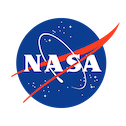


The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2020. California Institute of Technology. Government sponsorship acknowledged. 